In [1]:
%matplotlib inline
import torch
import networkx as nx
import matplotlib.pyplot as plt

D:\Anaconda\envs\tor1131py37\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def visualize_graph(G, color):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([0])
    nx.draw_networkx(G, pos=nx.spring_layout(G, seed=42), with_labels=False, node_color=color, cmap="Set2")

def visualize_embedding(h, color, epoch=None, loss=None):
    plt.figure(figsize=(7,7))
    plt.xticks([])
    plt.yticks([])
    h = h.detach().cpu().numpy()
    plt.scatter(h[:,0], h[:, 1], s=140, c=color, cmap="Set2")
    if epoch is not None and loss is not None:
        plt.xlabel(f'Epoch:{epoch}, Loss:{loss.item():.4f}', fontsize=16)
    plt.show()

### 数据集:Zachary's karate club network.
* 该图描述了一个空手道俱乐部会员的社交关系，以34名会员作为节点，如果两位会员在俱乐部之外仍保持社交关系，则在节点间增加一条边。每个节点具有一个34维的特征向量，一共有78条边。在收集数据的过程中，管理人员 Jon 和 练 Mr Hi(化名)之间产生了冲突，会员们选择了站队，一半会员跟随 Mt Hi成立了新俱乐部，剩下一半会员找了新教练或退出了俱乐部。    
* 要对队员进行二分类，也就是对节点进行二分类。
### 数据集介绍
* 可以直接参考其APl: [htps://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub](htps://pytorch-geometric.readthedocs.io/en/latest/modules/datasets.html#torch_geometric.datasets.KarateClub)

In [3]:
from torch_geometric.datasets import KarateClub
dataset = KarateClub()
print(f'Dataset: {dataset}:')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of features:{dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: KarateClub():
Number of graphs: 1
Number of features:34
Number of classes: 4


In [4]:
# Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])
# x:[samples, in_dim]
# edge_index: [, edges] 两个向量，向量一source存储源点，向量二target存储指向目标节点
# y: [labels]
# train_mask=[y的这个位置是否要mask掉，mask掉的位置不参与损失计算] bool值
data = dataset[0]    # first graph
print(data)

Data(x=[34, 34], edge_index=[2, 156], y=[34], train_mask=[34])


In [6]:
edge_index = data.edge_index
print(edge_index)

tensor([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,
          1,  1,  1,  1,  1,  1,  1,  2,  2,  2,  2,  2,  2,  2,  2,  2,  2,  3,
          3,  3,  3,  3,  3,  4,  4,  4,  5,  5,  5,  5,  6,  6,  6,  6,  7,  7,
          7,  7,  8,  8,  8,  8,  8,  9,  9, 10, 10, 10, 11, 12, 12, 13, 13, 13,
         13, 13, 14, 14, 15, 15, 16, 16, 17, 17, 18, 18, 19, 19, 19, 20, 20, 21,
         21, 22, 22, 23, 23, 23, 23, 23, 24, 24, 24, 25, 25, 25, 26, 26, 27, 27,
         27, 27, 28, 28, 28, 29, 29, 29, 29, 30, 30, 30, 30, 31, 31, 31, 31, 31,
         31, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 33, 33, 33, 33, 33,
         33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33, 33],
        [ 1,  2,  3,  4,  5,  6,  7,  8, 10, 11, 12, 13, 17, 19, 21, 31,  0,  2,
          3,  7, 13, 17, 19, 21, 30,  0,  1,  3,  7,  8,  9, 13, 27, 28, 32,  0,
          1,  2,  7, 12, 13,  0,  6, 10,  0,  6, 10, 16,  0,  4,  5, 16,  0,  1,
          2,  3,  0,  2, 30, 32, 33,  2, 33,  0,  4

In [10]:
print(data.train_mask)

tensor([ True, False, False, False,  True, False, False, False,  True, False,
        False, False, False, False, False, False, False, False, False, False,
        False, False, False, False,  True, False, False, False, False, False,
        False, False, False, False])


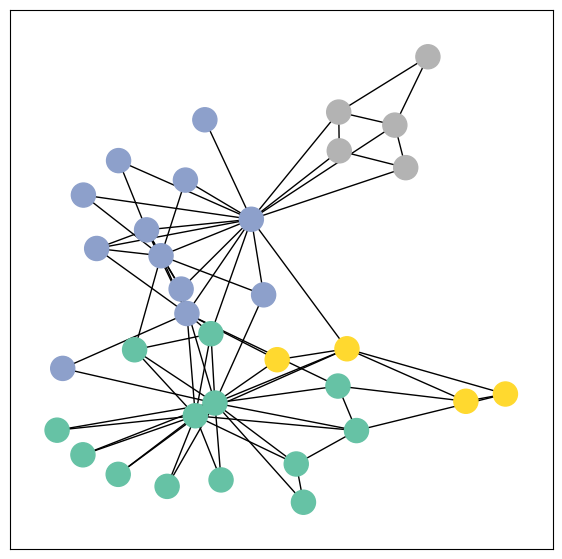

In [7]:
from torch_geometric.utils import to_networkx
G = to_networkx(data, to_undirected=True)
visualize_graph(G, color=data.y)

In [8]:
import torch.nn as nn
from torch_geometric.nn import GCNConv

class GCN(nn.Module):
    def __init__(self):
        super().__init__()
        torch.manual_seed(1234)
        self.conv1 = GCNConv(dataset.num_features, 4)   # 输入特征维度， 输出特征维度
        self.conv2 = GCNConv(4, 4)
        self.conv3 = GCNConv(4, 2)
        self.cls = nn.Linear(2, dataset.num_classes)

    def forward(self, x, edge_index):
        h = self.conv1(x, edge_index)
        h = h.tanh()
        h = self.conv2(h, edge_index)
        h = h.tanh()
        h = self.conv3(h, edge_index)
        # 输出
        h = h.tanh()

        # cls
        out = self.cls(h)
        return out, h

model = GCN()
print(model)

GCN(
  (conv1): GCNConv(34, 4)
  (conv2): GCNConv(4, 4)
  (conv3): GCNConv(4, 2)
  (cls): Linear(in_features=2, out_features=4, bias=True)
)


Embedding shape:[34, 2]


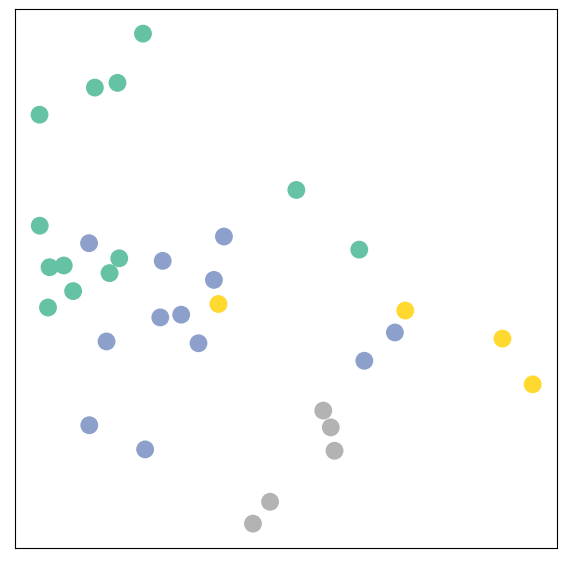

In [9]:
# 输出特征展示
model = GCN()
_, h = model(data.x, data.edge_index)
print(f'Embedding shape:{list(h.shape)}')
visualize_embedding(h, color=data.y)

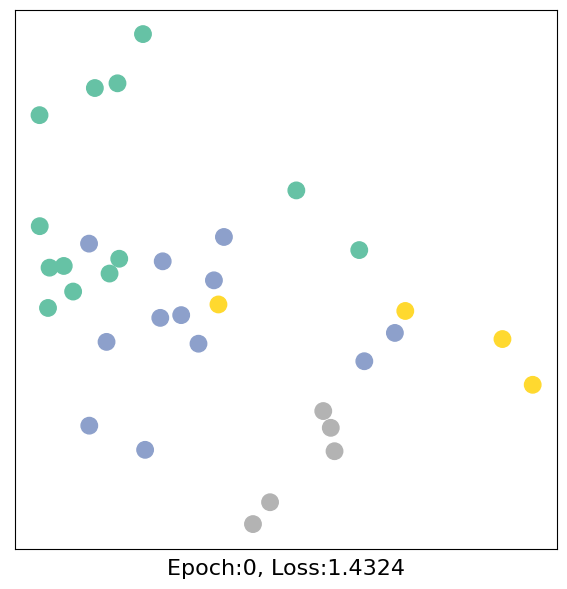

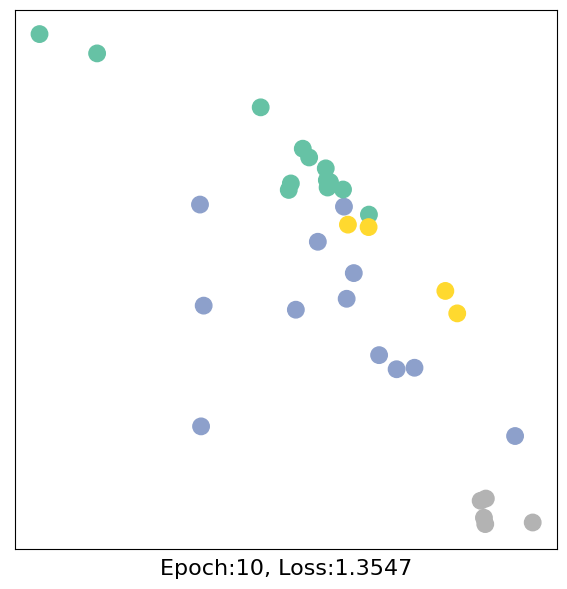

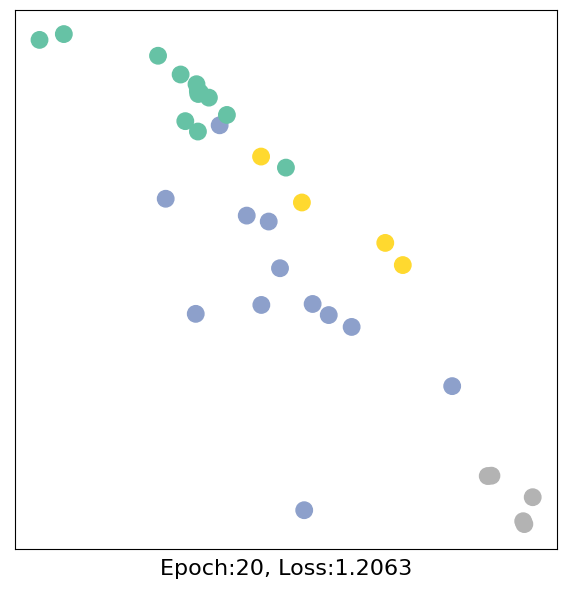

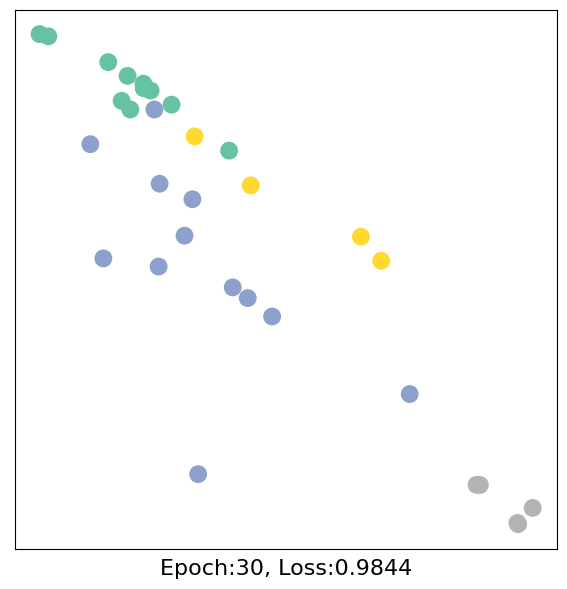

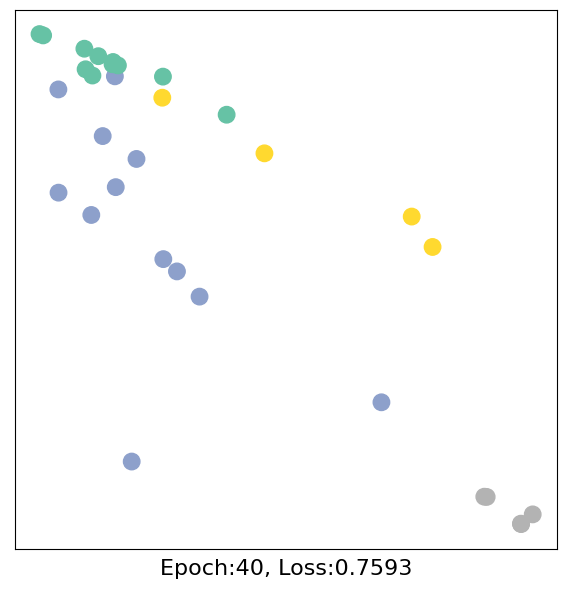

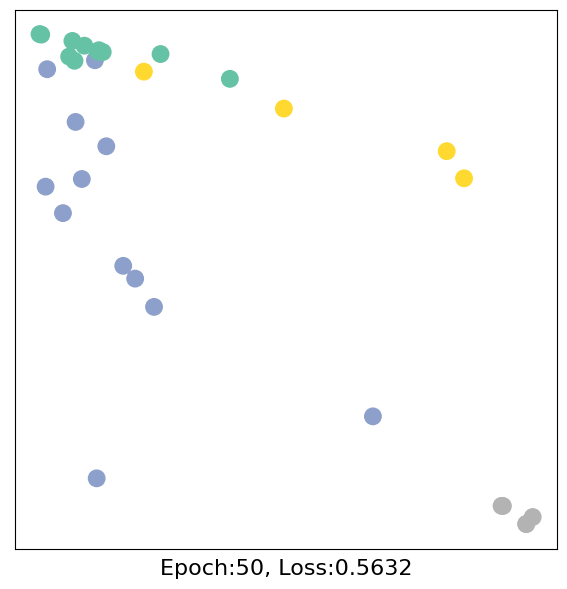

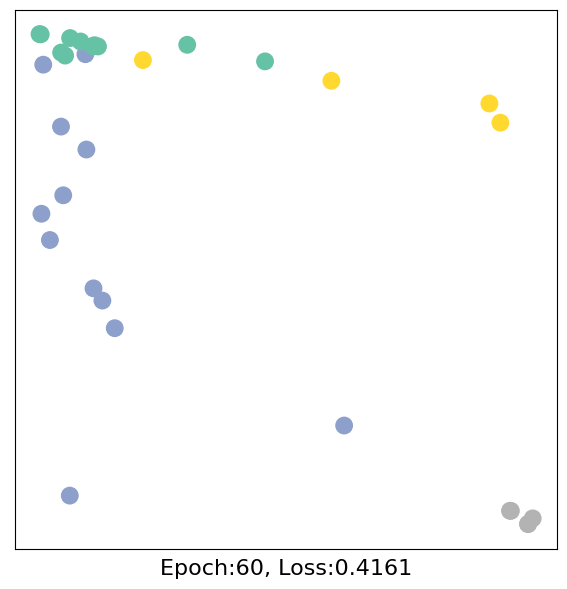

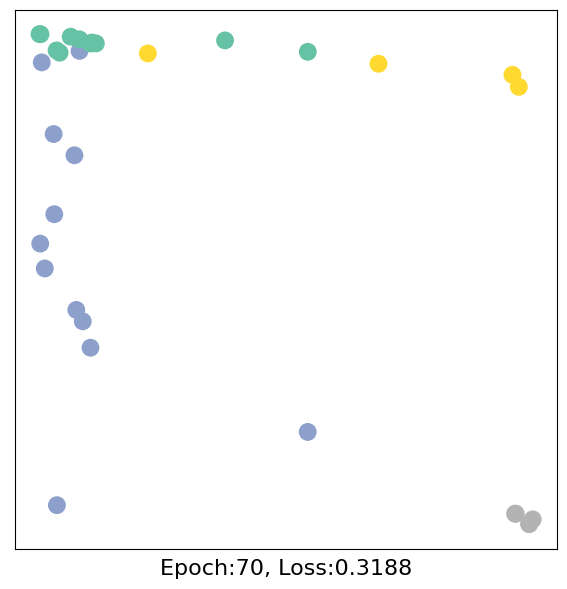

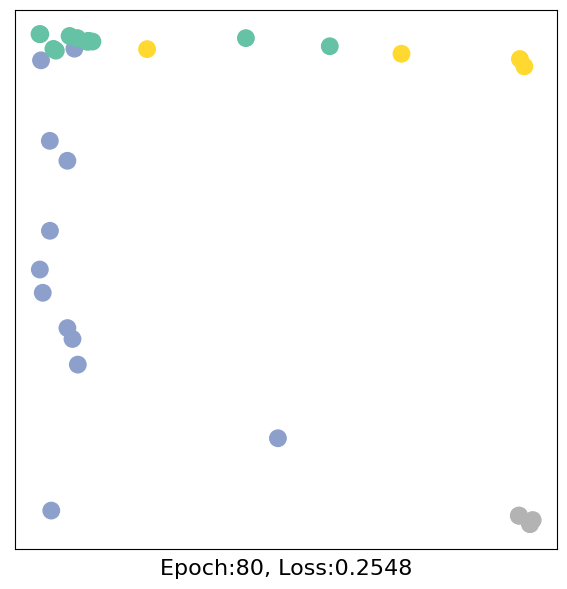

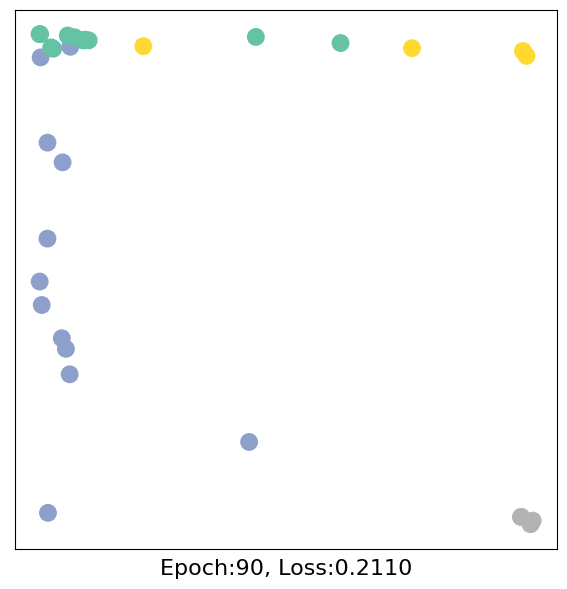

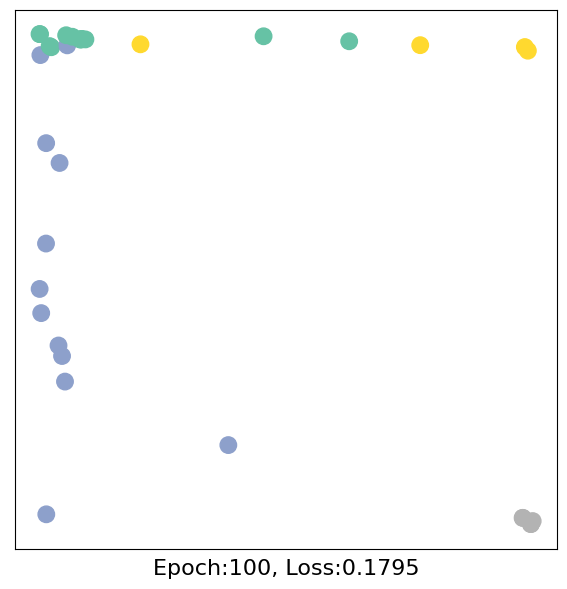

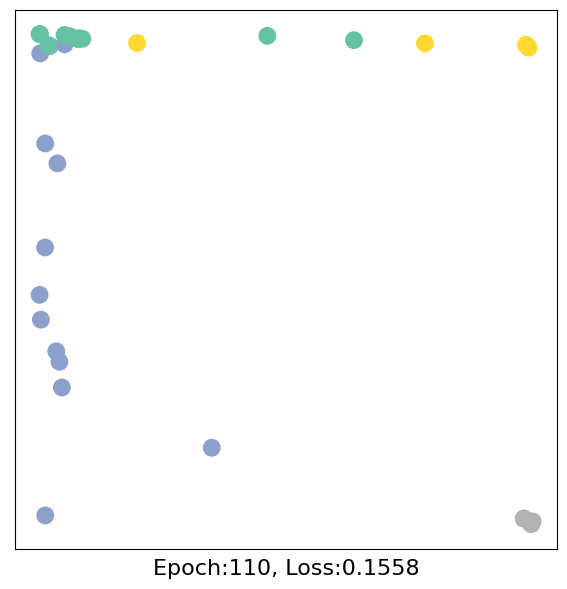

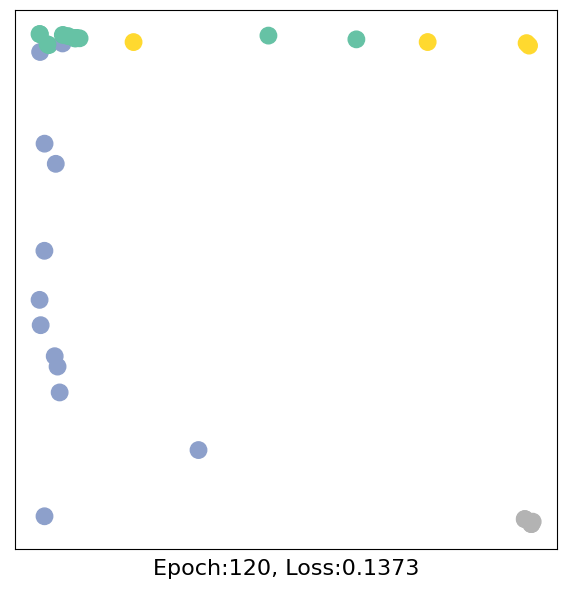

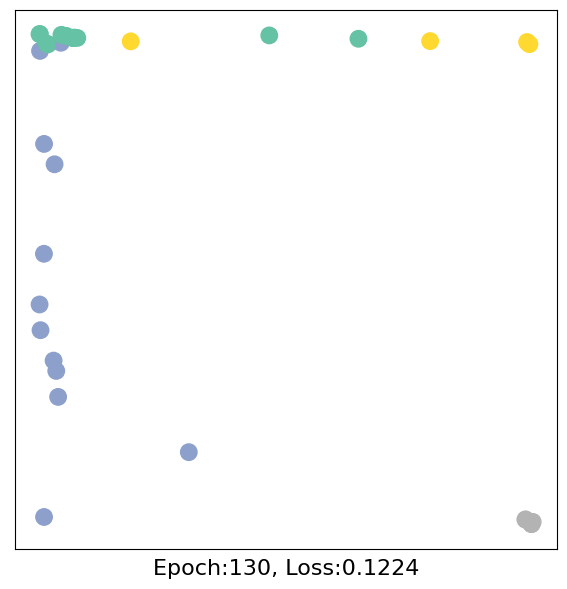

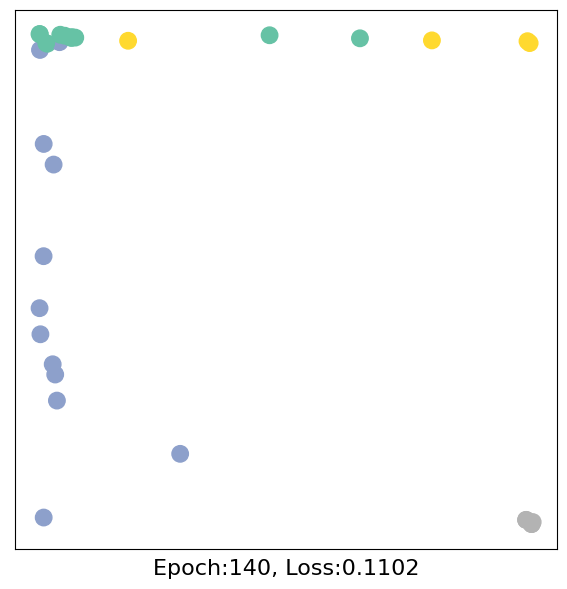

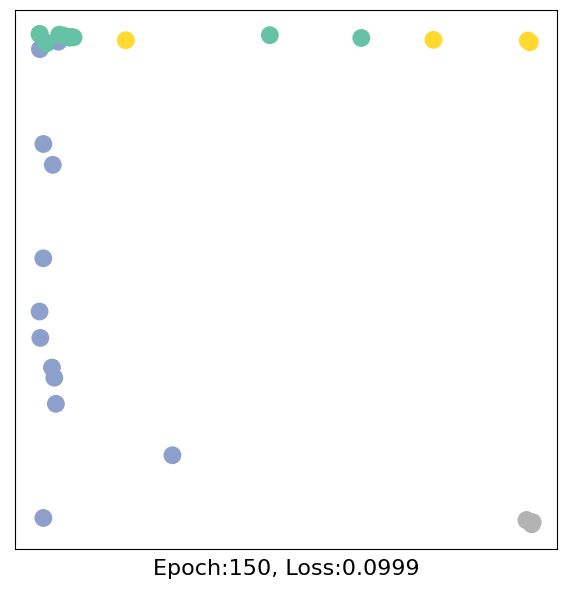

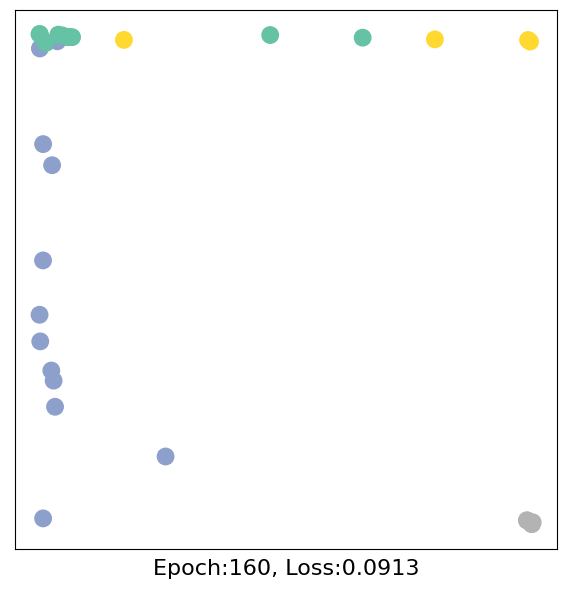

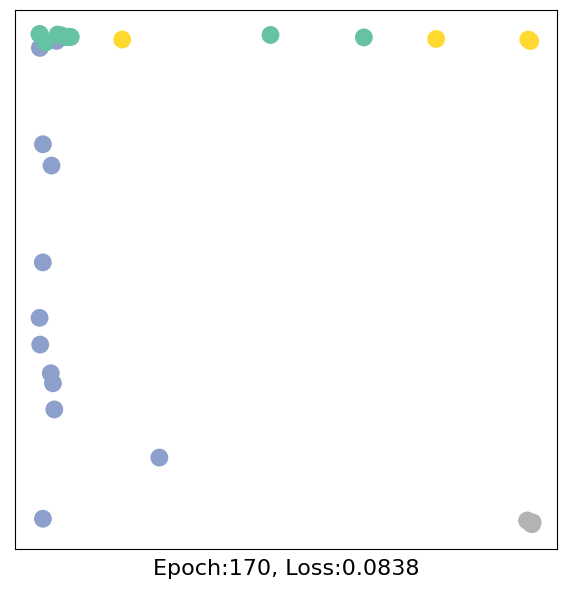

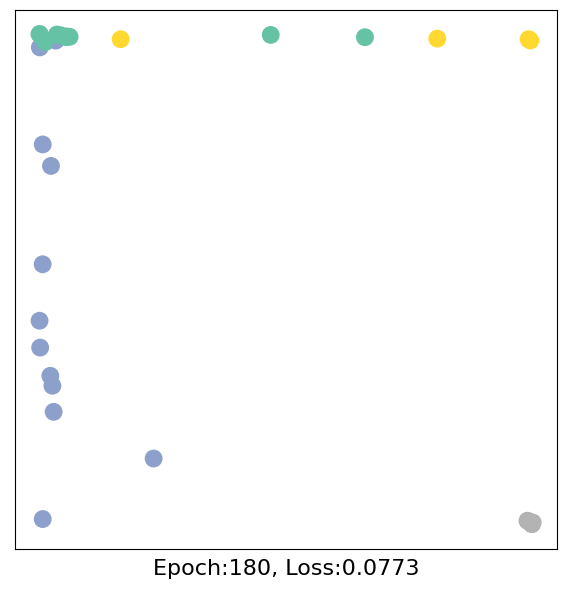

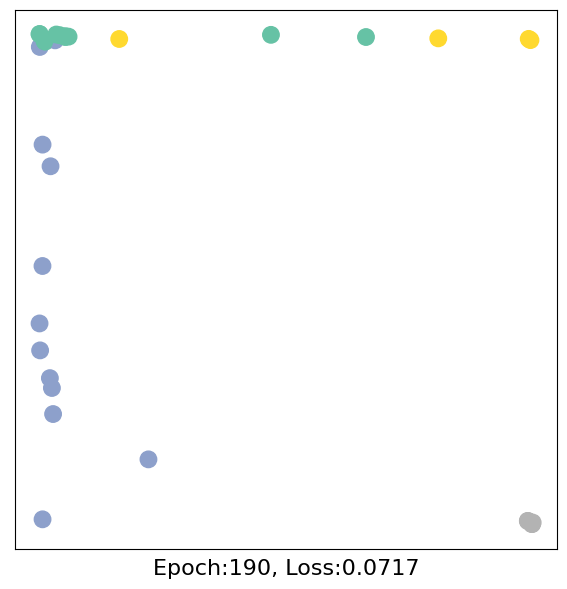

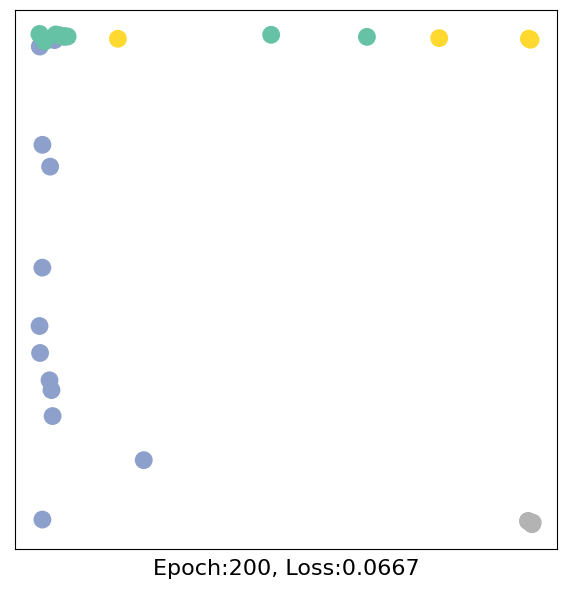

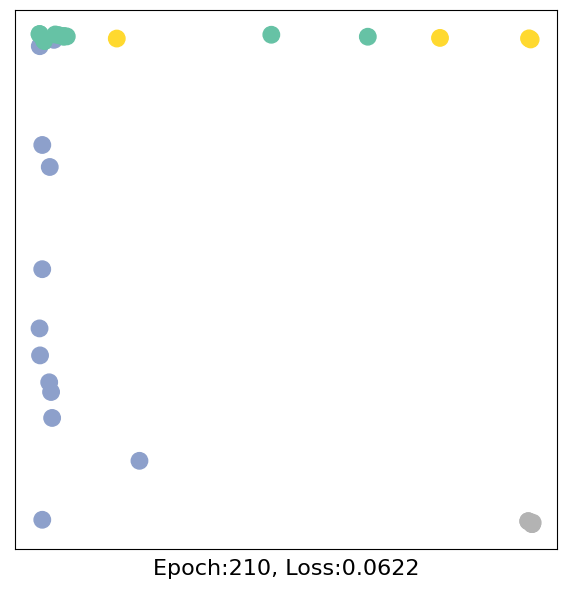

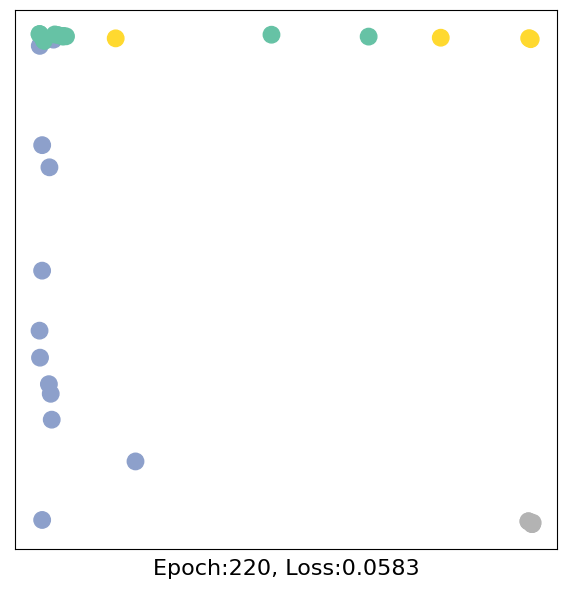

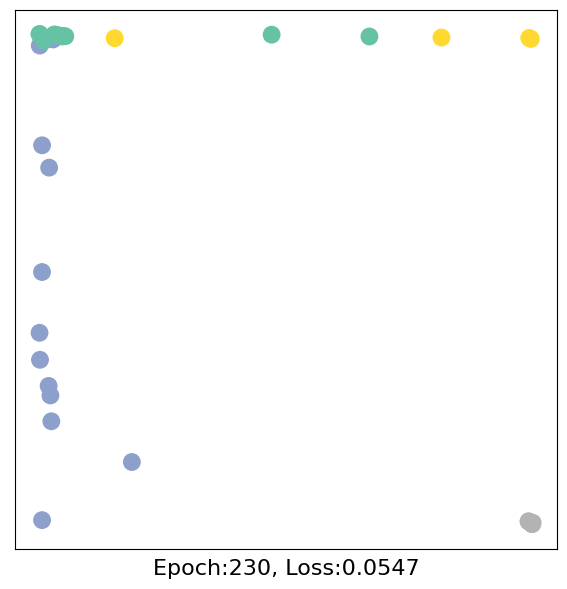

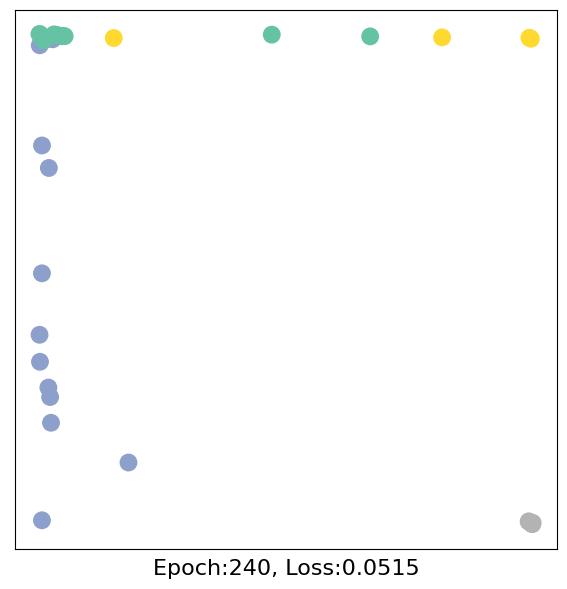

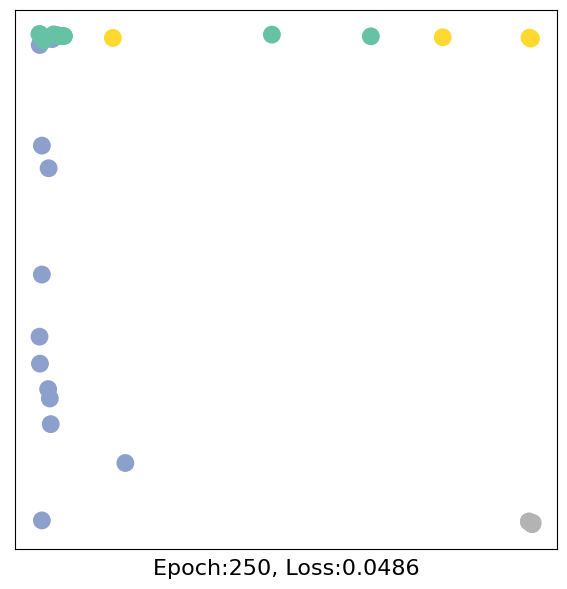

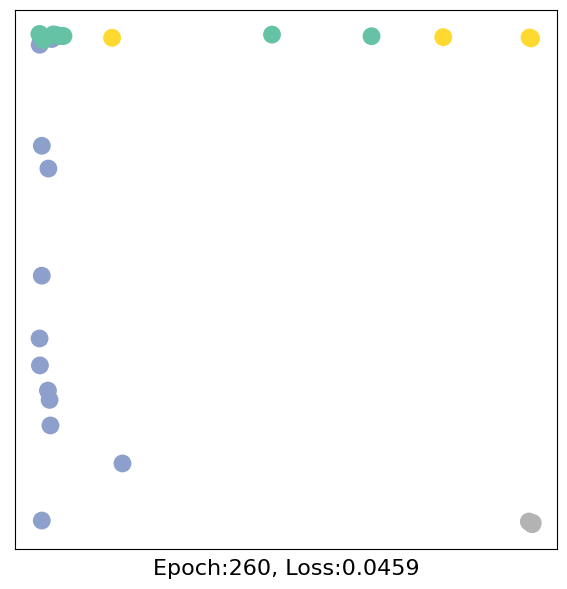

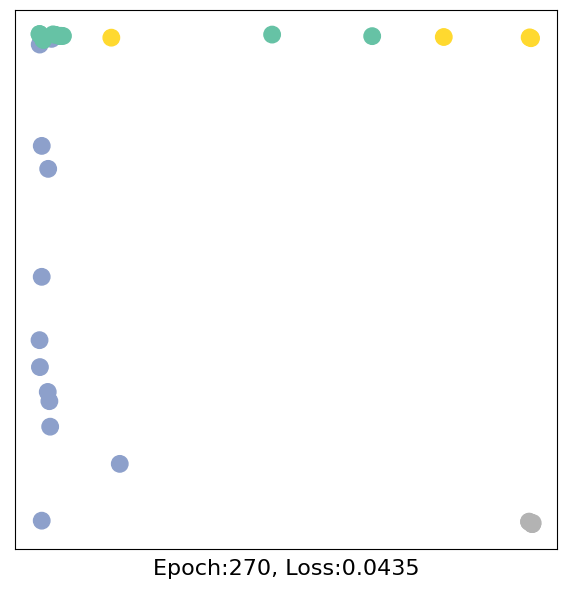

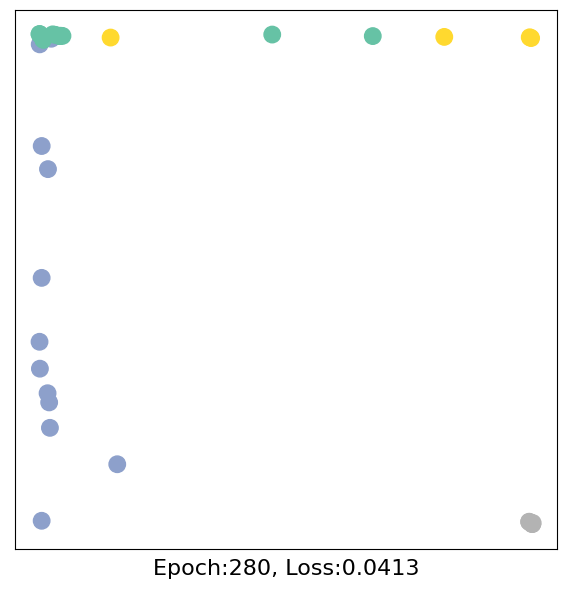

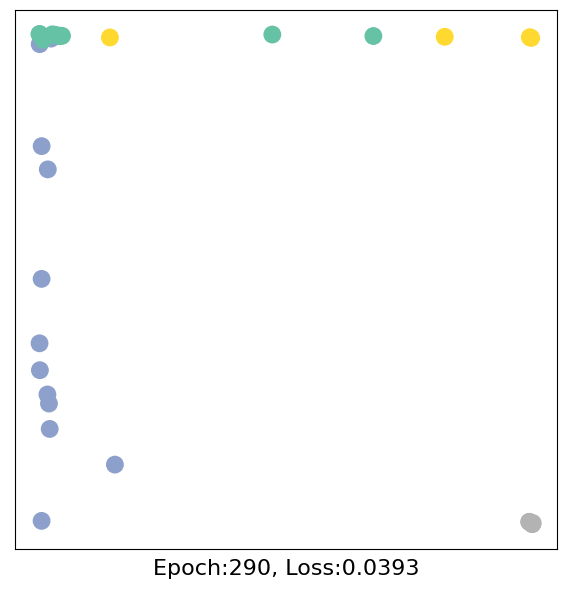

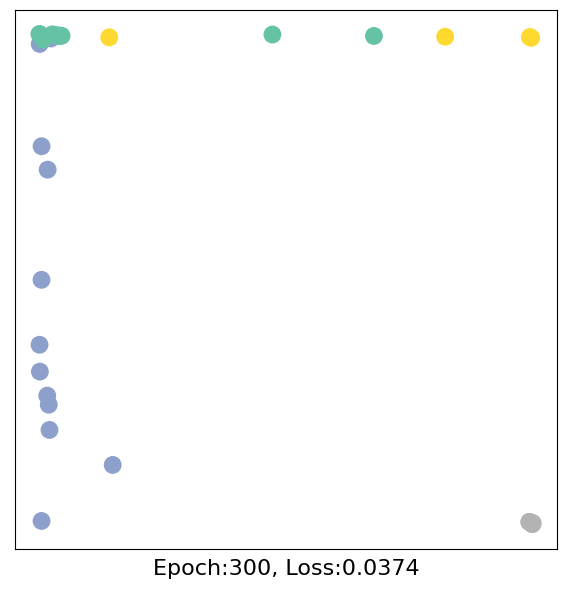

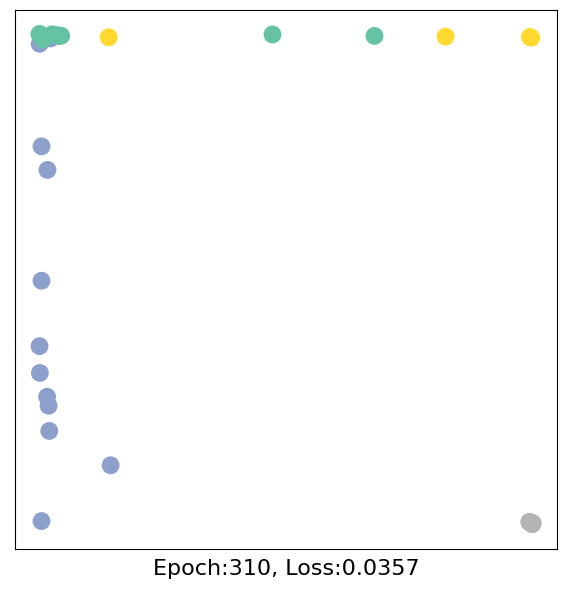

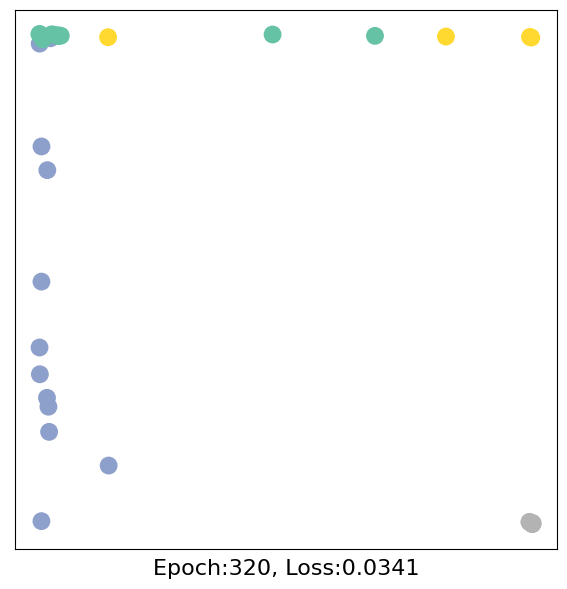

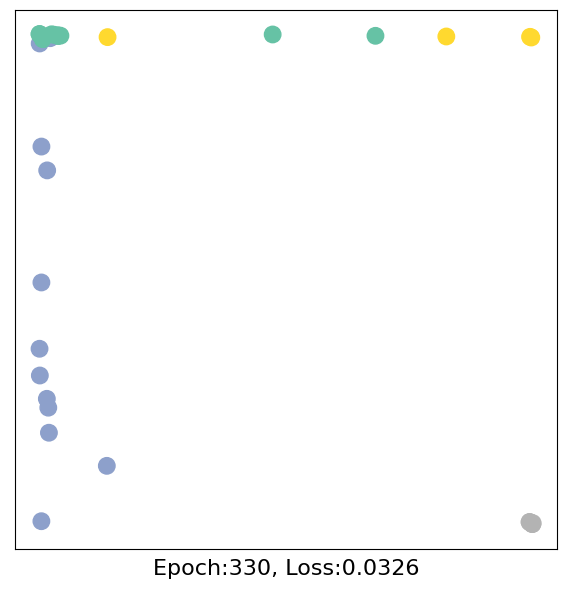

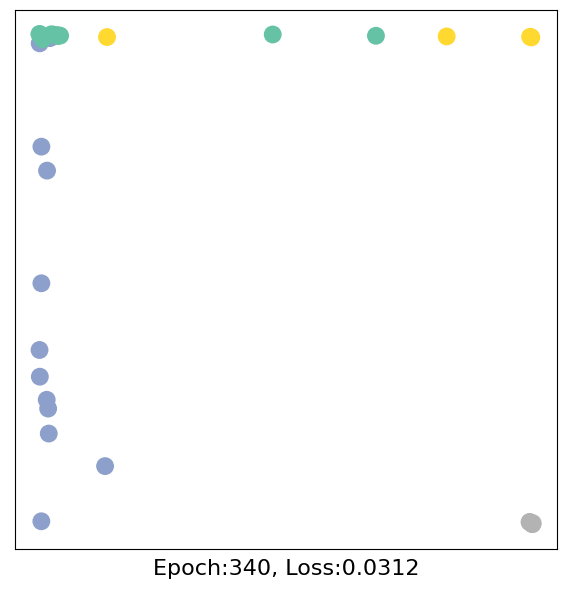

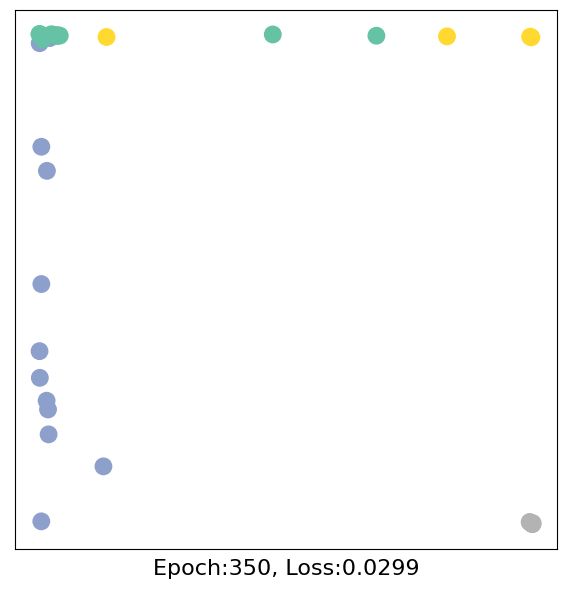

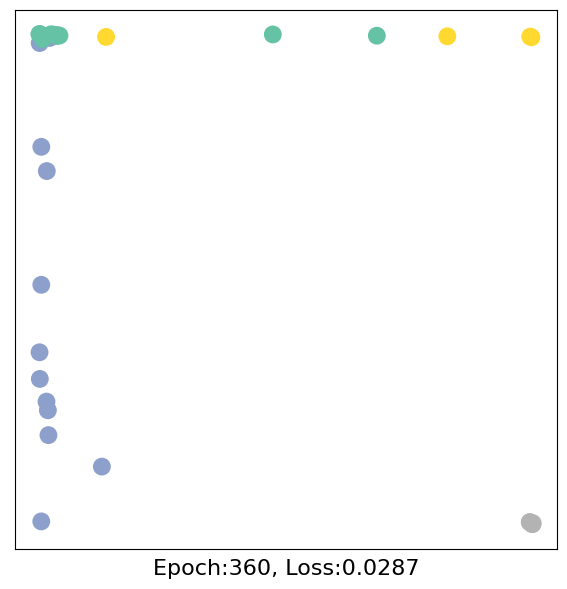

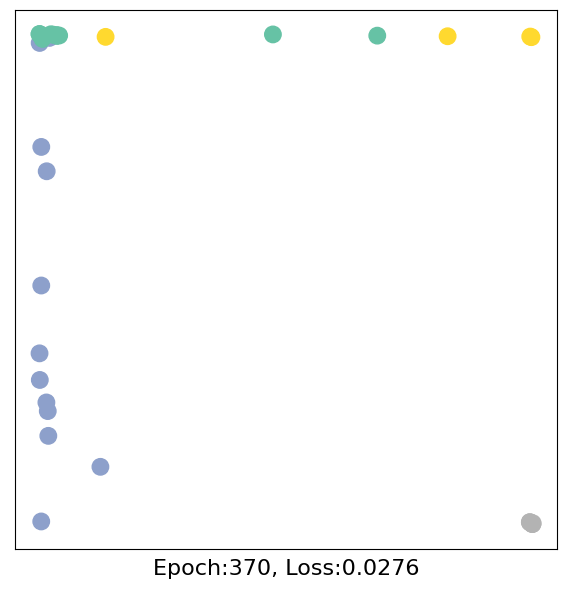

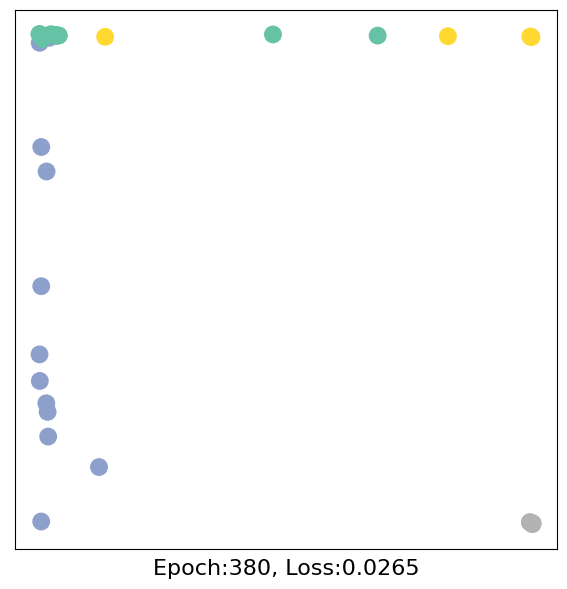

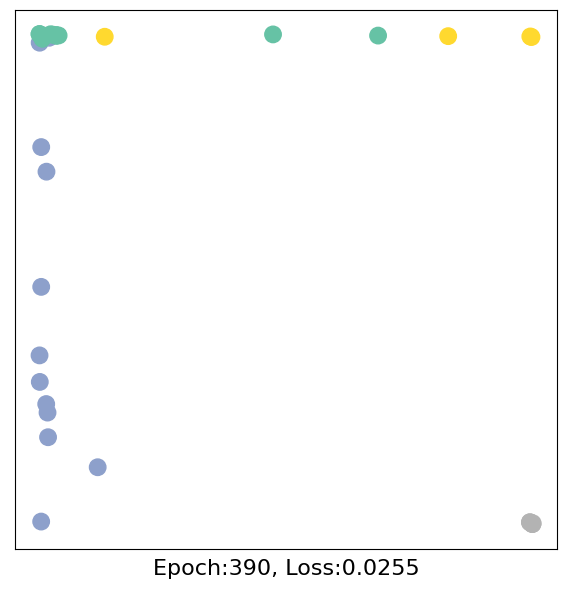

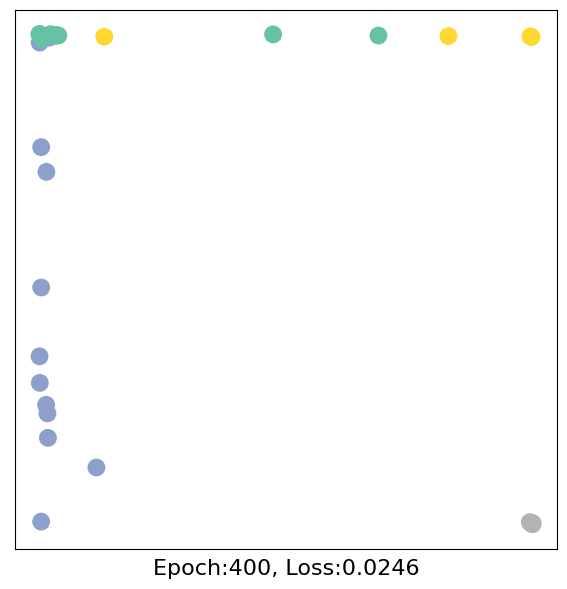

In [11]:
# train
import time
model = GCN()
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)

def train(data):
    optimizer.zero_grad()
    out, h = model(data.x, data.edge_index)    # h是2维向量，方便画图
    loss = criterion(out[data.train_mask], data.y[data.train_mask])    # semi-supervised
    loss.backward()
    optimizer.step()
    return loss, h

for epoch in range(401):
    loss, h = train(data=data)
    if epoch % 10 ==0:
        visualize_embedding(h=h, color=data.y, epoch=epoch, loss=loss)
        time.sleep(0.3)